In [21]:
import nbimporter
import euclidean

In [22]:
import pandas as pd
import numpy as np
import osmnx as ox
ox.settings.use_cache = True
ox.settings.log_console = True
import pulp as plp
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.image as img

## 1) Preprocess data

Load the data with areas, i.e. demand points and warehouses.

In [23]:
df_a = pd.read_csv("data/areas_latlong.csv")
df_a.head()

Area        lat       long
0  Helsingin keskusta  60.168741  24.940895
1           Punavuori  60.161237  24.936505
2     Kaartinkaupunki  60.165214  24.947222
3         Kaivopuisto  60.156843  24.956721
4                Eira  60.156191  24.938375

In [24]:
df_w = pd.read_csv("data/warehouses.csv")
df_w.head()

Warehouse        lat       long  mincap  maxcap
0       Kamppi  60.167458  24.931075     200     600
1  Munkkiniemi  60.198270  24.875989     200     600
2       Pasila  60.202785  24.925894     500    1500
3      Maunula  60.229804  24.930579     300     900
4        Malmi  60.251022  25.010563     500    1500

Extract the data and print general statistics.

In [25]:
Nd = len(df_a)
Nw = len(df_w)

demand_lat = df_a["lat"].tolist()
demand_long = df_a["long"].tolist()
warehouse_lat = df_w["lat"].tolist()
warehouse_long = df_w["long"].tolist()

warehouse_min = df_w["mincap"]
warehouse_max = df_w["maxcap"]

# Set total demand
D = 5000

In [26]:
print(f"Number of demand points: {Nd}")
print(f"Number of warehouses: {Nw}")
print(f"Total demand: {D}")
print(f"Sum of minimum capacities of warehouses: {sum(warehouse_min)}")
print(f"Sum of maximum capacities of warehouses: {sum(warehouse_max)}")
print(f"Average demand per demand point: {round(D/Nd,1)}")
print(f"Average demand per warehouse: {round(D/Nw,1)}")

Number of demand points: 74
Number of warehouses: 8
Total demand: 5000
Sum of minimum capacities of warehouses: 2400
Sum of maximum capacities of warehouses: 7200
Average demand per demand point: 67.6
Average demand per warehouse: 625.0


## 2) Initialize a road network

Initialize the road network, save to file and load from file.

In [27]:
#G = ox.graph_from_point(center_point=(60.15, 25.01), dist=15000,network_type="drive",dist_type="bbox")
#ox.save_graphml(G, 'data/graph.graphml')
G = ox.load_graphml('data/graph.graphml')

Plot the network and the data.

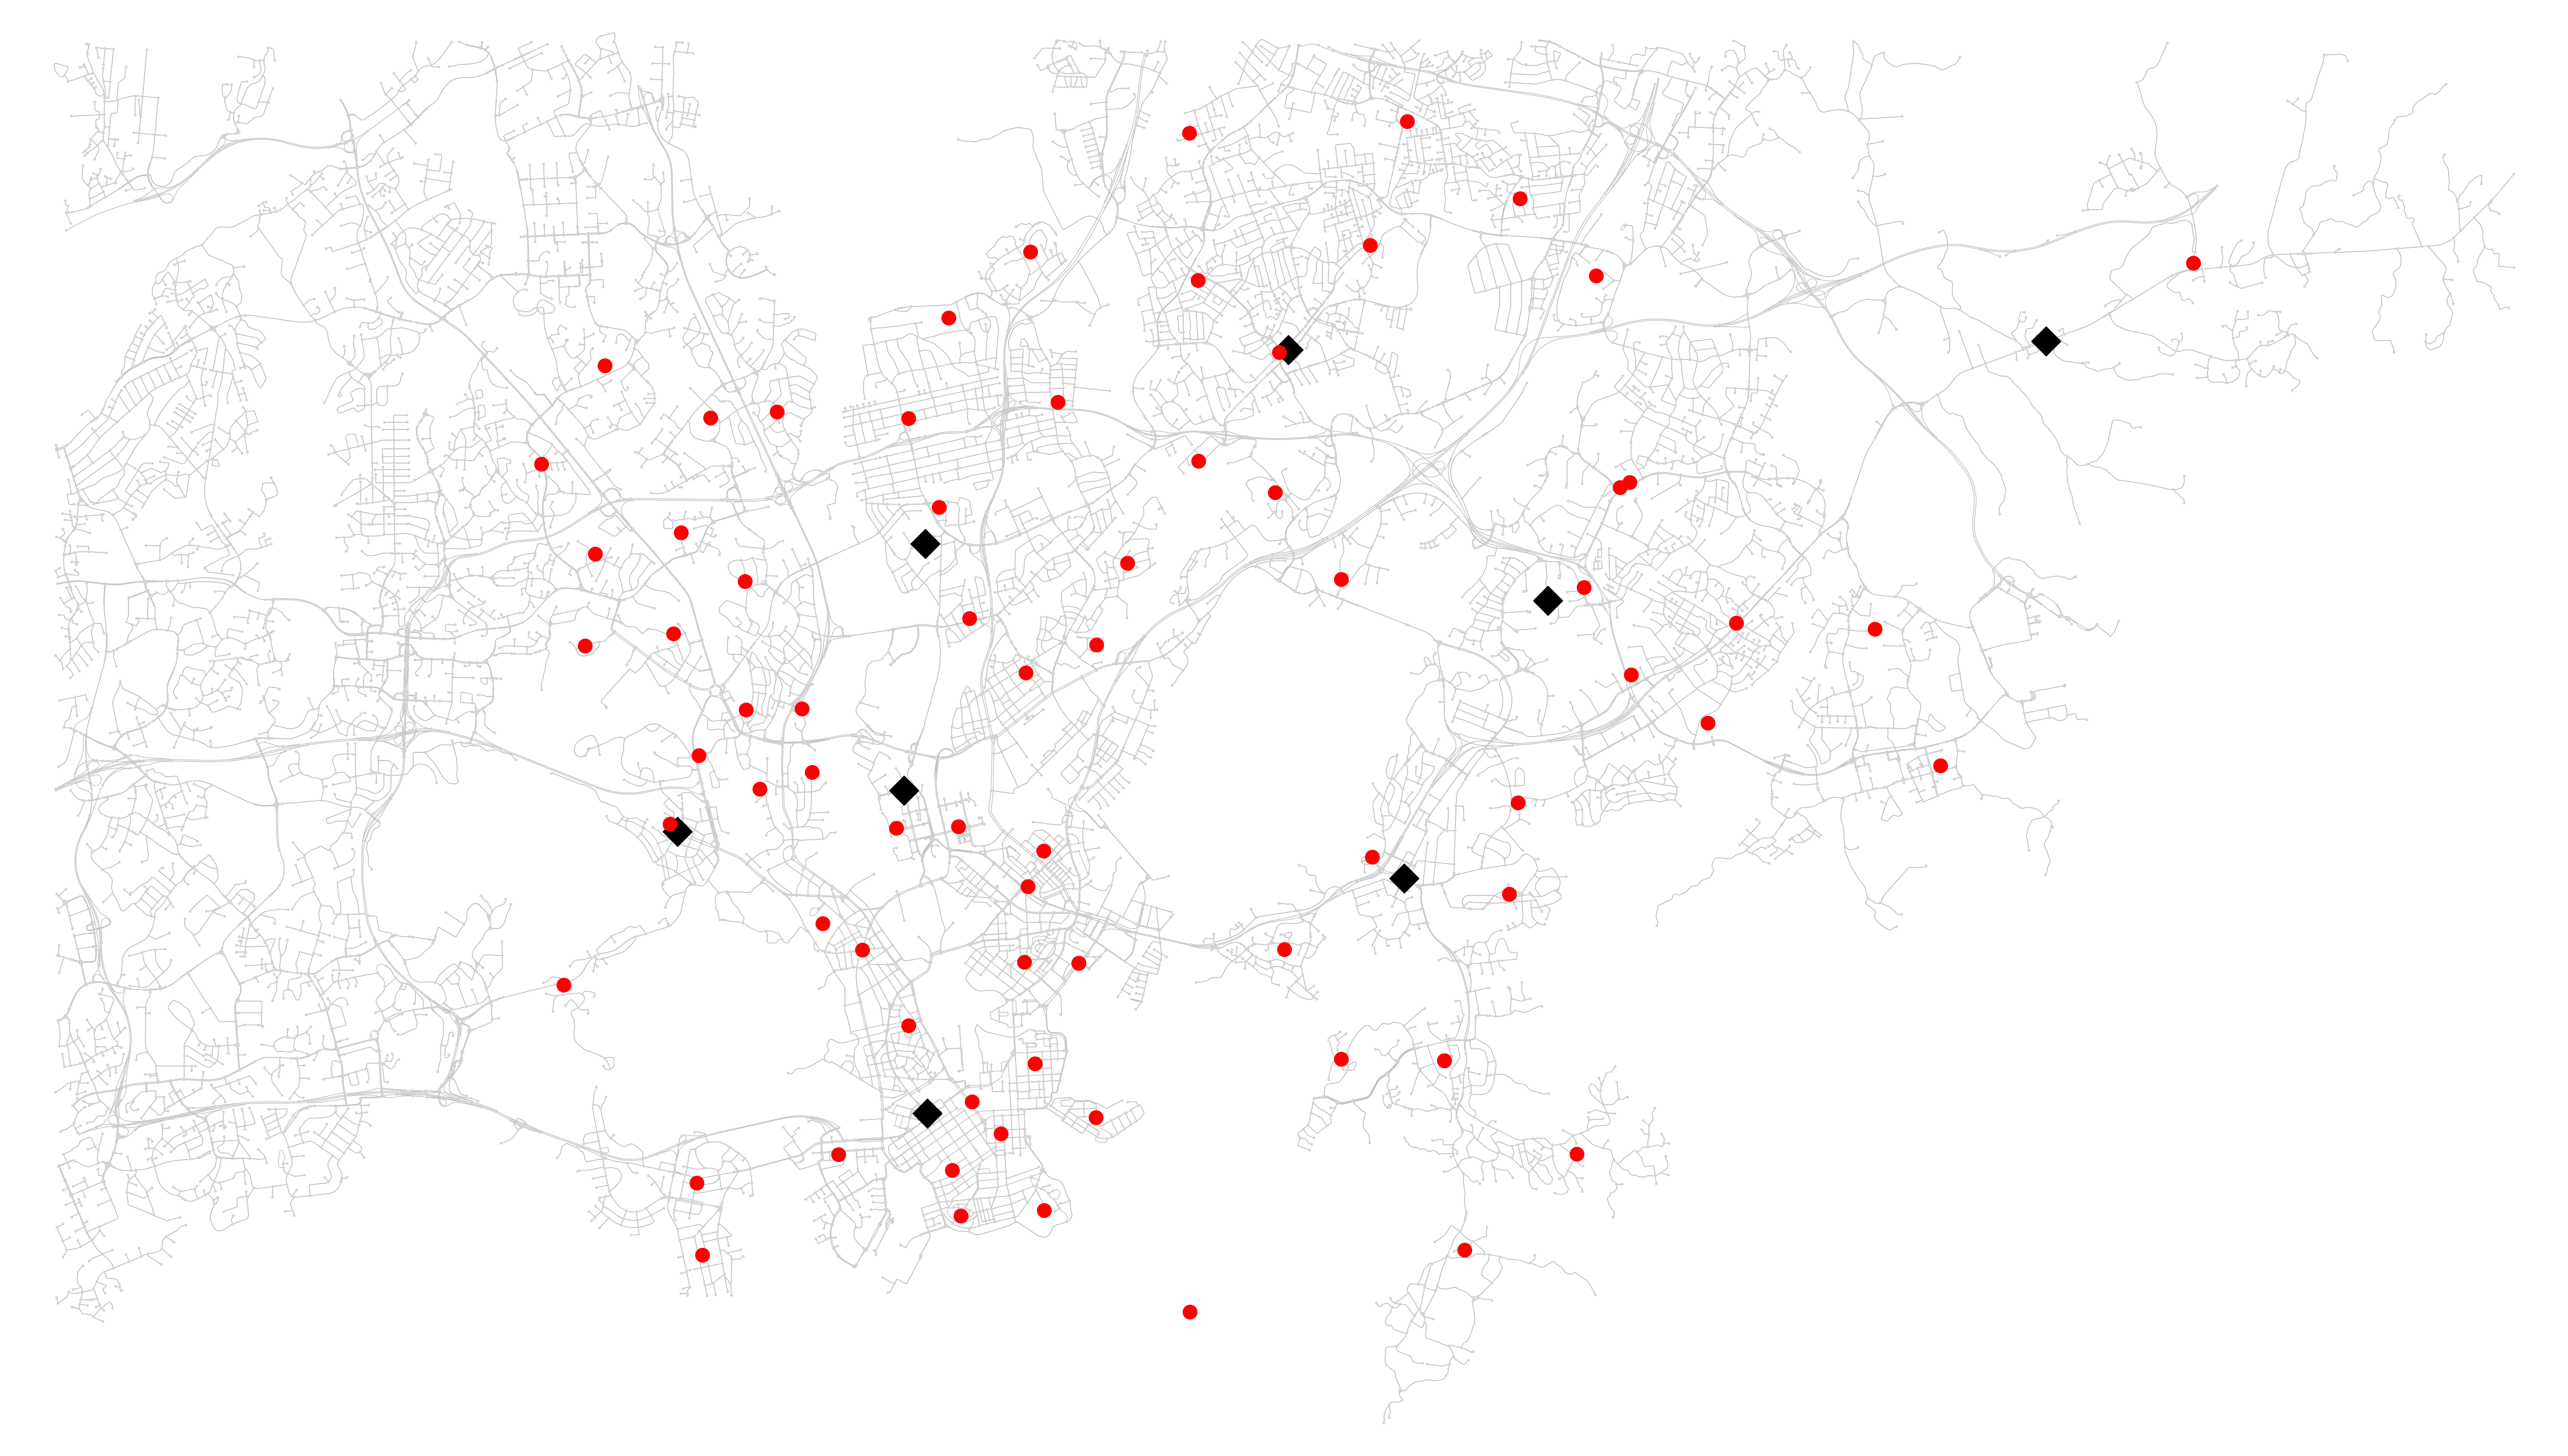

In [28]:
fig,axis = ox.plot_graph(G, figsize=(65,65),bgcolor="white",node_color="lightgrey",edge_color = "silver", show=False, close=False)
for i in range(Nw):
    wx = warehouse_lat[i]
    wy = warehouse_long[i]
    plt.plot(wy,wx,c='black',marker='D',markersize=30)

for j in range(Nd):
    lx = demand_lat[j]
    ly = demand_long[j]
    plt.plot(ly,lx,c='r',marker='o',markersize=20)

filename = 'results/network.jpg'
fig.savefig(filename, bbox_inches='tight', dpi=150)

## 3) Implement optimization model

In [29]:
def build_model(cost,avgdemand):
    opt_model = plp.LpProblem(name="MIP_Model")

    # Sets
    set_I = range(0, Nw)
    set_J = range(0, Nd)

    # Variables
    x  = {(i,j):
            plp.LpVariable(cat=plp.LpBinary, name="x_{0}_{1}".format(i,j)) 
        for i in set_I for j in set_J}

    o  = {(i):
            plp.LpVariable(cat=plp.LpBinary, name="o_{0}".format(i)) 
        for i in set_I}

    # Constraints
    for i in set_I:
        opt_model += (plp.lpSum([x[i,j]*avgdemand for j in set_J]) <= warehouse_max[i]* o[i])
        
    for i in set_I:
        opt_model += (plp.lpSum([x[i,j]*avgdemand for j in set_J]) >= warehouse_min[i] * o[i])

    constraints_eq = {j : opt_model.addConstraint(
            plp.LpConstraint(
                e=plp.lpSum(x[i,j] for i in set_I),
                sense=plp.LpConstraintEQ,
                rhs=1,
                name="constraint_eq_{0}".format(j)
            )
        ) for j in set_J}

    # Objective
    objective = plp.lpSum(x[i,j] * cost[i,j] for i in set_I for j in set_J)

    # for minimization
    opt_model.sense = plp.LpMinimize
    opt_model.setObjective(objective)
    return opt_model

## 5) Preprocessing and analysis of road network

First task is to transform the warehouse and demand point locations into node-points of the graph. 

In [30]:
approx_demand_points = []
approx_warehouses = []

# Approximate warehouse and demand points
for i in range(Nw):
    w_approx = ox.distance.nearest_nodes(G, warehouse_long[i],warehouse_lat[i], return_dist=False)
    approx_warehouses.append(w_approx)

for j in range(Nd):
    d_approx = ox.distance.nearest_nodes(G, demand_long[j],demand_lat[j], return_dist=False)
    approx_demand_points.append(d_approx)

Construct routes going through each warehouse and each demand point (due to difficulties in plotting only nodes).

In [31]:
approx_warehouses_routes = []
approx_demand_points_routes = []
for i in range(Nw-1):
    j = i+1
    w1 = approx_warehouses[i]
    w2 = approx_warehouses[j]
    route = nx.shortest_path(G, w1, w2, weight='lenght')
    approx_warehouses_routes.append(route)
for i in range(Nd-1):
    j = i+1
    d1 = approx_demand_points[i]
    d2 = approx_demand_points[j]
    route = nx.shortest_path(G, d1, d2, weight='lenght')
    approx_demand_points_routes.append(route)

Plot these 'routes' with only the origins and destinations. Compare with original points.

In [32]:
#fig, axis = ox.plot_graph(G, figsize=(65,65),bgcolor="white",node_size=0,edge_color = "silver", show=False, close=False)
#
#for j in range(Nw):
#    lx = warehouse_lat[j]
#    ly = warehouse_long[j]
#    plt.plot(ly,lx,c='r',marker='P',markersize=40)
#
#for route in approx_warehouses_routes[:-1]:
#    ox.plot_graph_route(G,route, route_color="blue", orig_dest_size=2000, route_linewidth=0, ax=axis, show=False, close=False)
#
#ox.plot_graph_route(G,approx_warehouses_routes[-1], route_color="blue", orig_dest_size=2000, route_linewidth=0, ax=axis)
#
#fig.savefig('results/warehouse_approx.jpg', bbox_inches='tight', dpi=150)

In [33]:
#fig, axis = ox.plot_graph(G, figsize=(65,65),bgcolor="white",node_size=0,edge_color = "silver", show=False, close=False)
#
#for j in range(Nd):
#    lx = demand_lat[j]
#    ly = demand_long[j]
#    plt.plot(ly,lx,c='r',marker='P',markersize=25)
#
#for route in approx_demand_points_routes[:-1]:
#    ox.plot_graph_route(G,route, route_color="blue", orig_dest_size=1000, route_linewidth=0, ax=axis, show=False, close=False)
#
#ox.plot_graph_route(G,approx_demand_points_routes[-1], route_color="blue", orig_dest_size=1000, route_linewidth=0, ax=axis)
#
#fig.savefig('results/demand_point_approx.jpg', bbox_inches='tight', dpi=150)

## 6) Solution for road network distances

Compute road distances using shortest path in our network. 

In [34]:
## Compute shortest paths
## Edges have speeds and times (equaling distance)
#G = ox.distance.add_edge_lengths(G) 
#
## Below for travel time instead of distance
##G = ox.add_edge_speeds(G) 
##G = ox.add_edge_travel_times(G) 
#
#c_road = np.zeros((Nw,Nd))
#for i in range(Nw):
#    for j in range(Nd):
#        c_road[i][j] = nx.shortest_path_length(G, approx_warehouses[i], approx_demand_points[j], weight='travel_time')

Save to and laod form csv-file.

In [35]:
#c_df = pd.DataFrame(c_road)
#c_df.to_csv("data/costs.csv", sep=";",index=False)
#c_df.to_csv("data/costs_time.csv", sep=";",index=False)

c_road = pd.read_csv("data/costs.csv", sep=";").to_numpy()
# Load also travel distance network for results

Solve the model with road distance as cost function.

In [36]:
avgdemand = int(D/Nd)
model_road = build_model(c_road,avgdemand)

model_road.solve(plp.PULP_CBC_CMD(msg=0))
print("Status:", plp.LpStatus[model_road.status])

Status: Optimal


Retrieve results.

In [37]:
from euclidean import get_res_dict
wh_to_demand_road = get_res_dict(model_road)

Build graphical solution.

In [38]:
color_palette = ["red","blue","green","orange","purple","pink","cyan","brown"]
colors_per_warehouse = []
routes_per_warehouse = []

for i in wh_to_demand_road:
    routes = [] # routes for warehouse i
    colors = []
    #w_approx = ox.distance.nearest_nodes(G, warehouse_long[i],warehouse_lat[i], return_dist=False)
    w_approx = approx_warehouses[i]
    for j in wh_to_demand_road[i]:
        #d_approx = ox.distance.nearest_nodes(G, demand_long[j],demand_lat[j], return_dist=False)
        d_approx = approx_demand_points[j]
        route = nx.shortest_path(G, w_approx, d_approx, weight='lenght')
        routes.append(route)
        colors.append(color_palette[i])
    routes_per_warehouse.append(routes)
    colors_per_warehouse.append(colors)

In [39]:
# Flatten routes and colors per warehouse
all_routes = [route for wroute in routes_per_warehouse for route in wroute]
all_colors = [color for wcolors in colors_per_warehouse for color in wcolors]

Plot the solution.

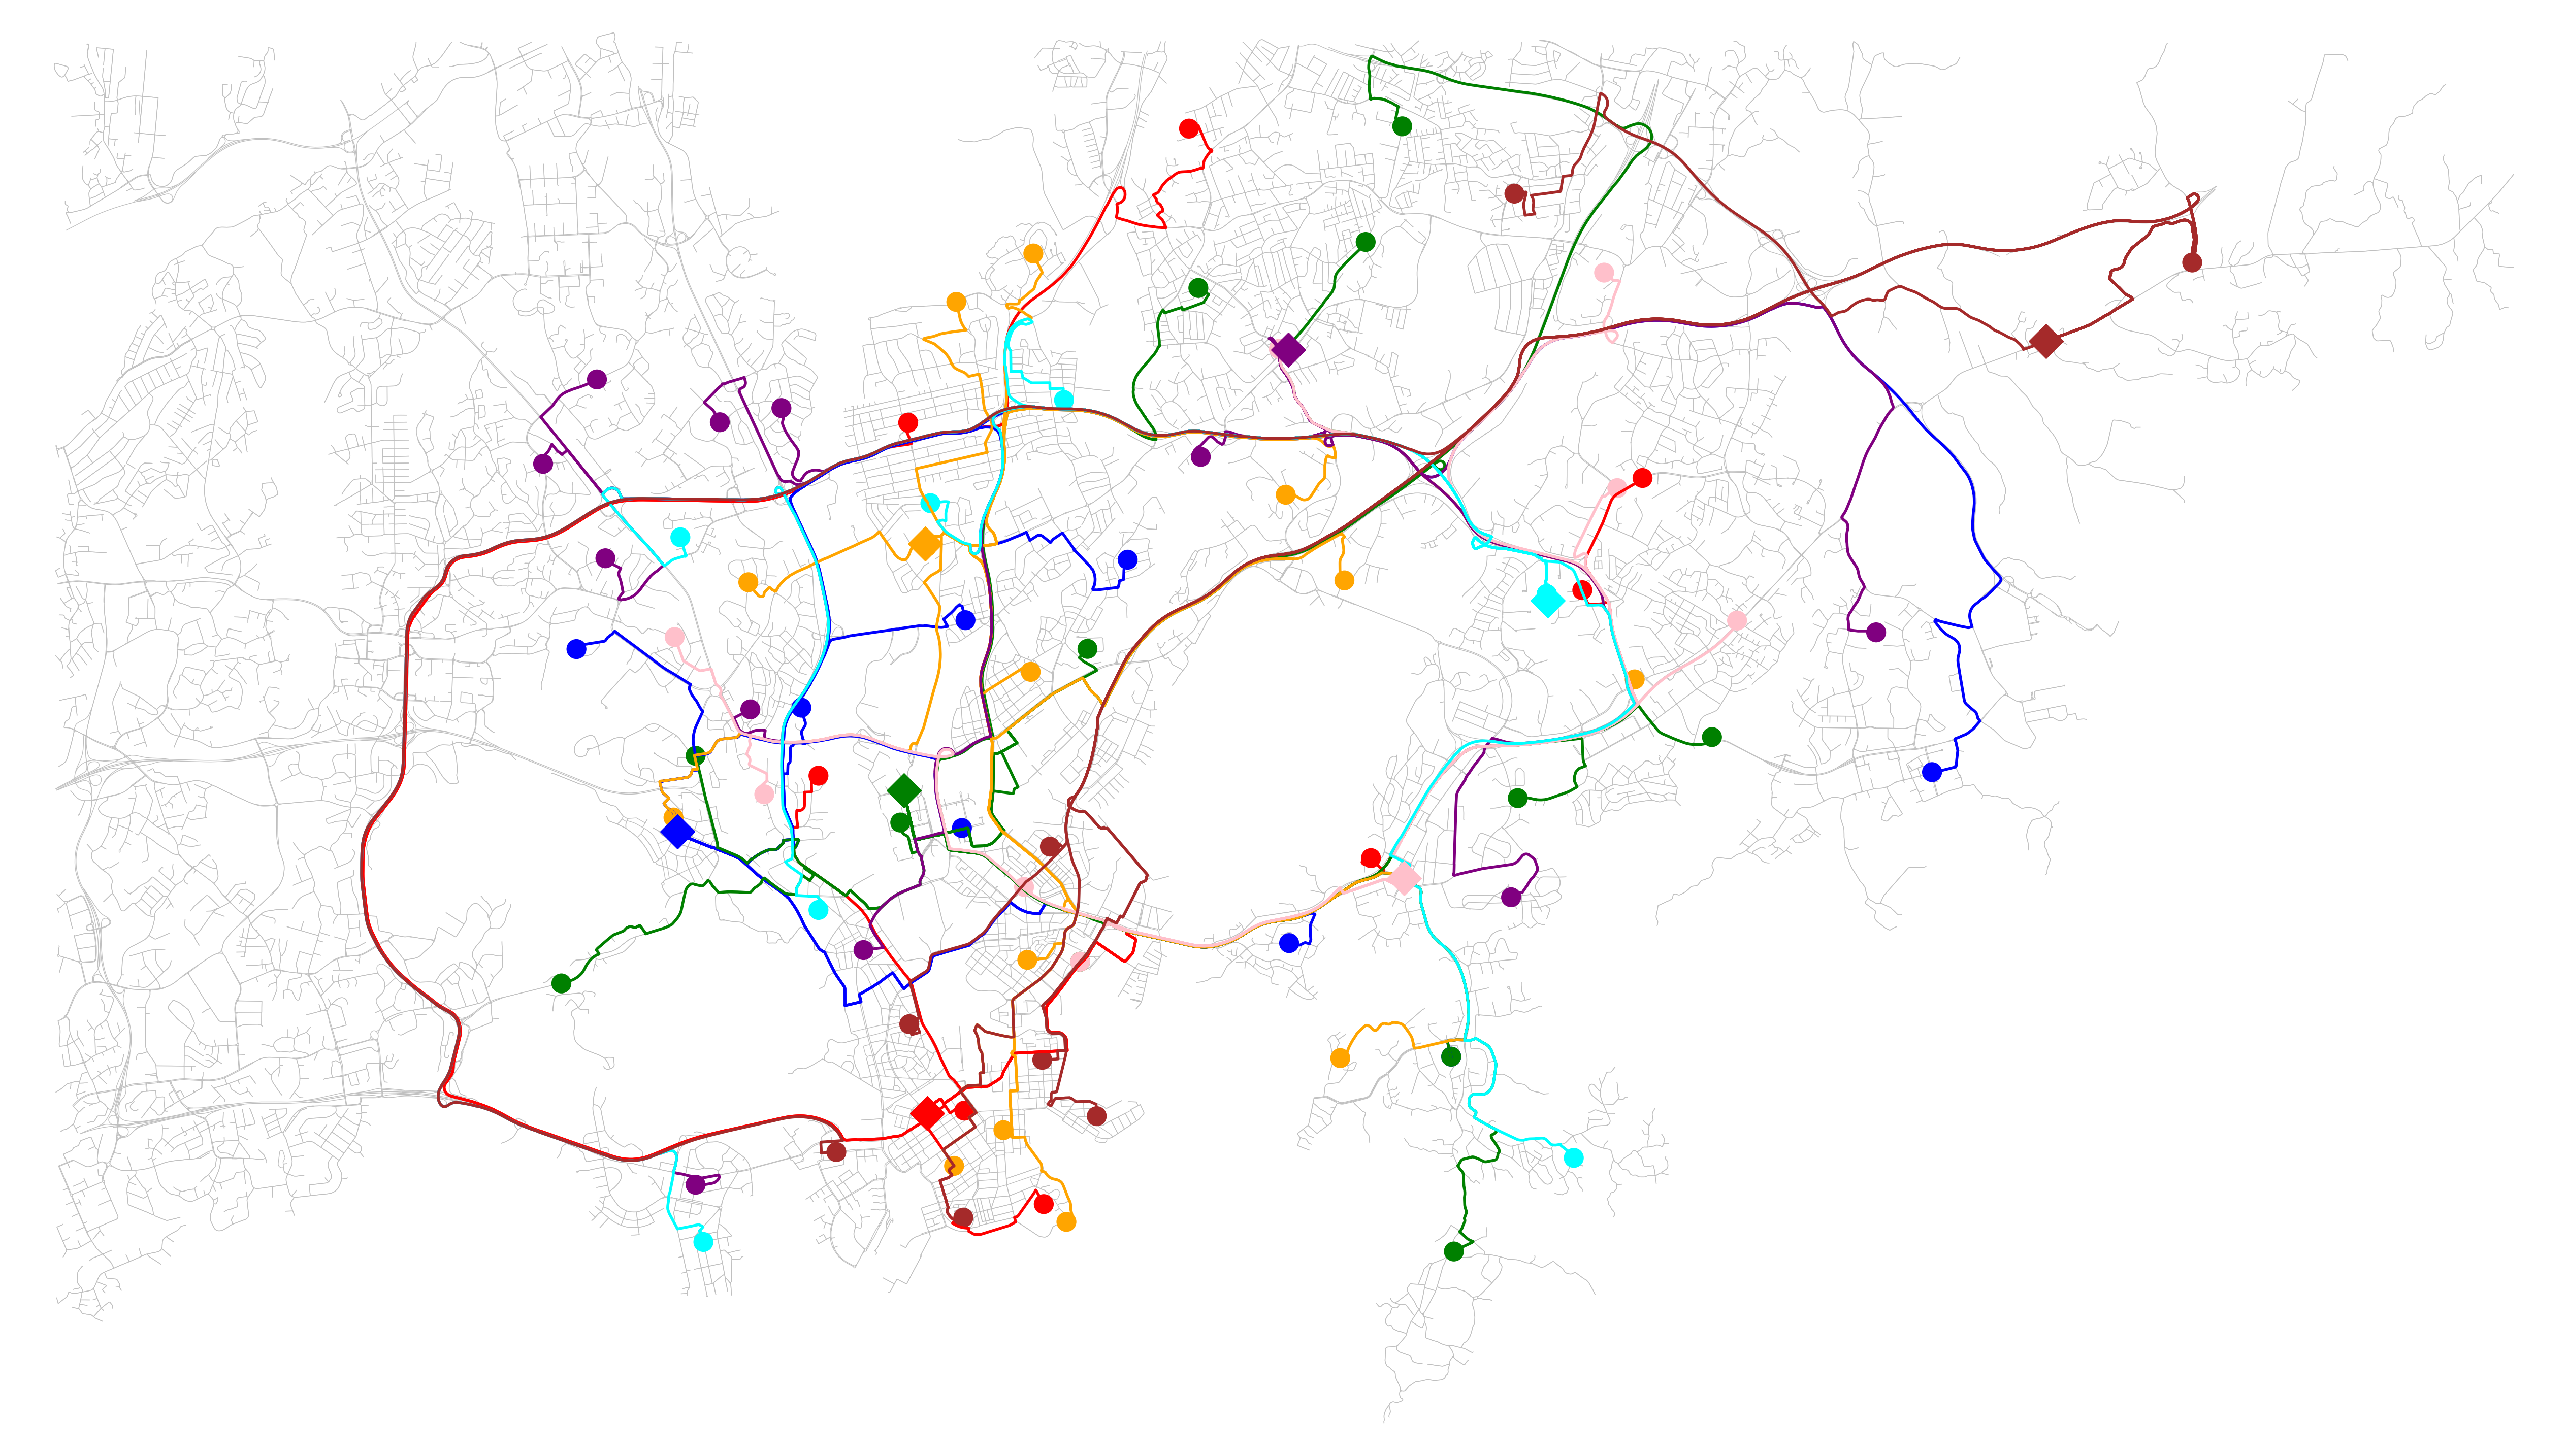

In [40]:
fig, axis = ox.plot_graph(G, figsize=(65,65),bgcolor="white",node_size=0,edge_color = "silver", show=False, close=False)

# Plot solution itself
ox.plot_graph_routes(G,all_routes, route_colors=all_colors, orig_dest_size=800, route_alpha=1.0, ax=axis, show=False, close=False)

# Plot warehouses with gps lon lat
for i in range(len(warehouse_lat)):
    x = warehouse_lat[i]
    y = warehouse_long[i]
    plt.plot(y,x,c=color_palette[i],marker='D',markersize=35)

fig.savefig('results/roadmap_solution.jpg', bbox_inches='tight', dpi=150)

Plot the solution for each warehouse separately.

In [41]:
#i = 0
#for wroutes in routes_per_warehouse:
#
#    fig, axis = ox.plot_graph(G, figsize=(65,65),bgcolor="white",node_size=0,edge_color = "silver", show=False, close=False)
#
#    # Plot routes from warehouse
#    ox.plot_graph_routes(G,wroutes, route_colors=colors_per_warehouse[i], orig_dest_size=800, route_alpha=1.0, ax=axis, show=False, close=False)
#
#    # Plot warehouse with gps lon lat
#    x = warehouse_lat[i]
#    y = warehouse_long[i]
#    plt.plot(y,x,c=color_palette[i],marker='D',markersize=45)
#
#    # Save files
#    filename = 'results/wh/wh' + str(i+1) + '.jpg'
#    fig.savefig(filename, bbox_inches='tight', dpi=150)
#
#    i += 1